In [1]:
import numpy as np
import pandas as pd   
import os
from pathlib import Path
import glob
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import nltk
import cv2
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud
import seaborn as sns


In [2]:
def load_data(N, mode='train'):
    with open(f'clevr/CLEVR_v1/questions/CLEVR_{mode}_questions.json') as f:
        data = json.load(f)
        data_set_size = len(data['questions'])
        records = []
        for k in np.random.uniform(0, data_set_size, N).astype(int):
            i = data['questions'][k]
            temp=[]
            for path in glob.glob(f'clevr/CLEVR_v1/images/{mode}/'+i['image_filename']): 
                temp.append(path)
            temp.append(i['question'])
            temp.append(i['answer'])
            records.append(temp)
    labels=['Path','Question','Answer']
    return pd.DataFrame.from_records(records, columns=labels)

In [3]:
train_df = load_data(699989, 'train')
val_df = load_data(149991, 'val')

In [4]:
train_df.head()

,Path,Question,Answer
0,clevr/CLEVR_v1/images/train/CLEVR_train_041080...,How many red things are small things or small ...,0
1,clevr/CLEVR_v1/images/train/CLEVR_train_019996...,What is the color of the small cylinder on the...,gray
2,clevr/CLEVR_v1/images/train/CLEVR_train_040989...,Are there any matte balls to the left of the b...,no
3,clevr/CLEVR_v1/images/train/CLEVR_train_040485...,Do the thing in front of the cyan matte thing ...,no
4,clevr/CLEVR_v1/images/train/CLEVR_train_042246...,Are there more rubber blocks than big objects?,no


In [5]:
val_df.head()

,Path,Question,Answer
0,clevr/CLEVR_v1/images/val/CLEVR_val_012405.png,The yellow object that is the same material as...,small
1,clevr/CLEVR_v1/images/val/CLEVR_val_007636.png,Does the small metallic cylinder have the same...,no
2,clevr/CLEVR_v1/images/val/CLEVR_val_014105.png,There is a metallic cylinder that is the same ...,small
3,clevr/CLEVR_v1/images/val/CLEVR_val_012237.png,Are there any other tiny metallic cubes of the...,no
4,clevr/CLEVR_v1/images/val/CLEVR_val_011853.png,How many other objects are the same material a...,3


In [6]:
def tokenize_qs(questions, tokenizer):
    res = set()
    for question in questions:
        res.update(tokenizer.tokenize(question))
    return res
    
tokenizer = tfds.deprecated.text.Tokenizer()

answer_set = set(np.append(train_df['Answer'].unique(),val_df['Answer'].unique()))
question_set = set(np.append(train_df['Question'].unique(),val_df['Question'].unique()))
vocab_set = tokenize_qs(question_set, tokenizer) | answer_set
    
encoder=tfds.deprecated.text.TokenTextEncoder(vocab_set)
answer_encoder=tfds.deprecated.text.TokenTextEncoder(answer_set)

In [7]:
def getFrequnctDict(data,column,isJoin=False):
    column_frequency = {}

    for _row in data[column]:
        if isJoin:
            _row = "_".join(_row.split())
        if(column_frequency.get(_row,-1) > 0):
            column_frequency[_row] += 1
        else:
            column_frequency[_row] = 1

    return column_frequency

def lineChart(data,column,top=20,isJoin=False):
    column_frequncy = getFrequnctDict(data,column,isJoin)
    sort_column_frequncy = sorted(list(column_frequncy.items()),key = lambda x: x[1],reverse=True)
    plt.bar([x[0] for x in sort_column_frequncy[:top]], [x[1]for x in sort_column_frequncy[:top]])
    plt.show()

def plotWordCloud(data,column,isJoin=False):
    column_frequncy = getFrequnctDict(data,column,isJoin)
    #https://www.geeksforgeeks.org/generating-word-cloud-python/
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = None, 
                    min_font_size = 10).generate_from_frequencies(column_frequncy)
    # plot the WordCloud image     
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("WordCloud on "+ column)  
    plt.show()

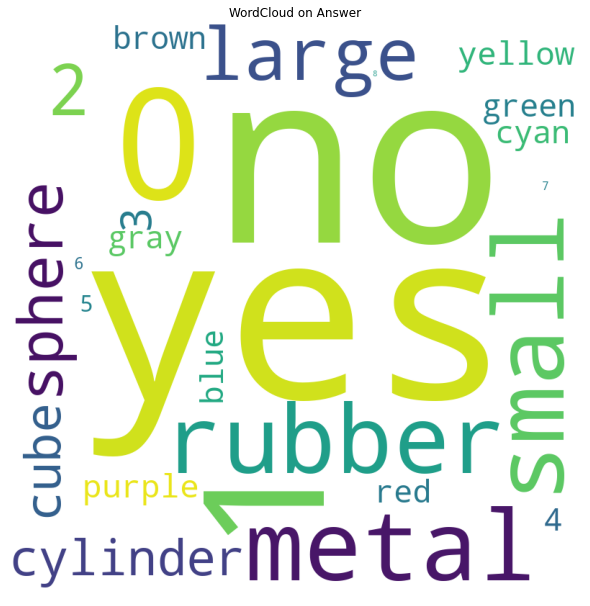

In [8]:
plotWordCloud(train_df, 'Answer')

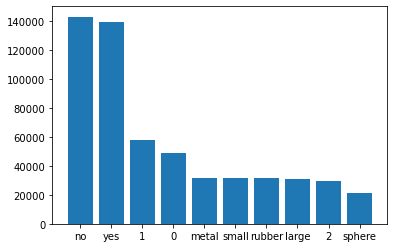

In [9]:
question_type_frequncy = lineChart(train_df, 'Answer', top=10)

/anaconda/envs/azureml_py36_tensorflow/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


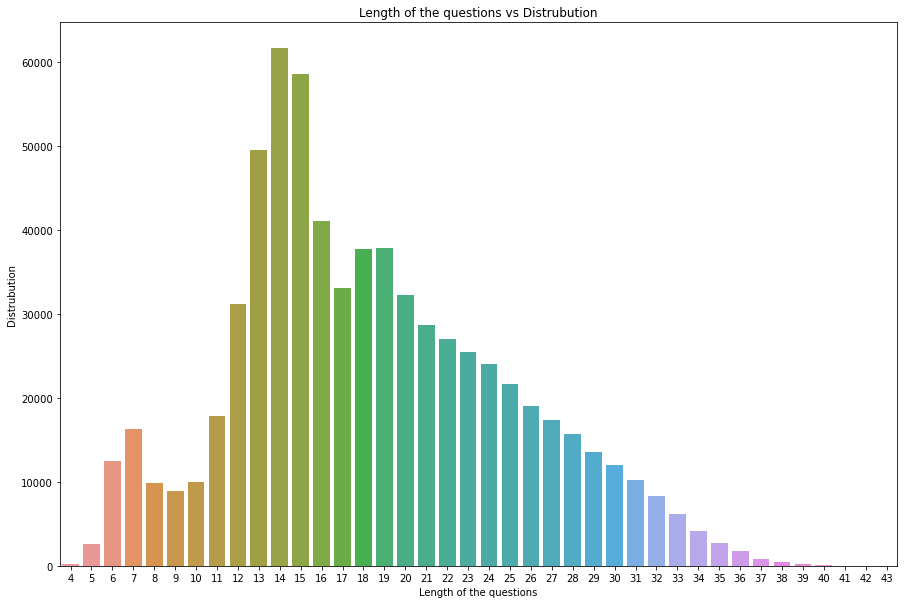

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(train_df["Question"].apply(lambda x: len(x.split())).values, ax=ax)
plt.title("Length of the questions vs Distrubution")
plt.xlabel("Length of the questions")
plt.ylabel("Distrubution")
plt.show()

In [11]:
temp_df = train_df
temp_df['Question type'] = temp_df["Question"].apply(lambda x: x.split()[0])
temp_df.head()

,Path,Question,Answer,Question type
0,clevr/CLEVR_v1/images/train/CLEVR_train_041080...,How many red things are small things or small ...,0,How
1,clevr/CLEVR_v1/images/train/CLEVR_train_019996...,What is the color of the small cylinder on the...,gray,What
2,clevr/CLEVR_v1/images/train/CLEVR_train_040989...,Are there any matte balls to the left of the b...,no,Are
3,clevr/CLEVR_v1/images/train/CLEVR_train_040485...,Do the thing in front of the cyan matte thing ...,no,Do
4,clevr/CLEVR_v1/images/train/CLEVR_train_042246...,Are there more rubber blocks than big objects?,no,Are


In [12]:
temp = temp_df
question_frequncy = getFrequnctDict(temp, "Question type",False)
question_frequncy_sorted = sorted(list(question_frequncy.items()),key = lambda x: x[1],reverse=True)
answer_frequncy = getFrequnctDict(temp, "Answer",False)
answer_frequncy_sorted = sorted(list(answer_frequncy.items()),key = lambda x: x[1],reverse=True)
top_question = [x[0] for x in question_frequncy_sorted[:50]]
top_aswers = [x[0] for x in answer_frequncy_sorted[:50]]
aggregations = {'Question': 'count'}
temp = pd.DataFrame(temp.groupby(['Question type','Answer'],as_index=False).agg(aggregations))
temp = temp[temp['Question']>=10]
temp = temp.pivot(index='Question type', columns='Answer', values='Question')

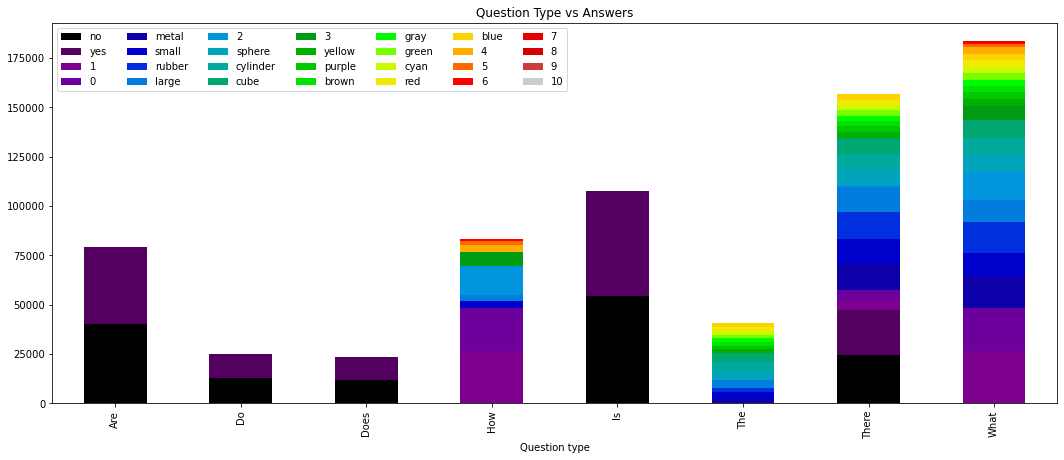

In [13]:
colors = plt.cm.nipy_spectral(np.linspace(0, 1, 28))
ax = temp.loc[:,top_aswers].plot.bar(stacked=True, figsize=(18,7), color=colors)
ax.legend(ncol = 7)
plt.title('Question Type vs Answers')
plt.show()

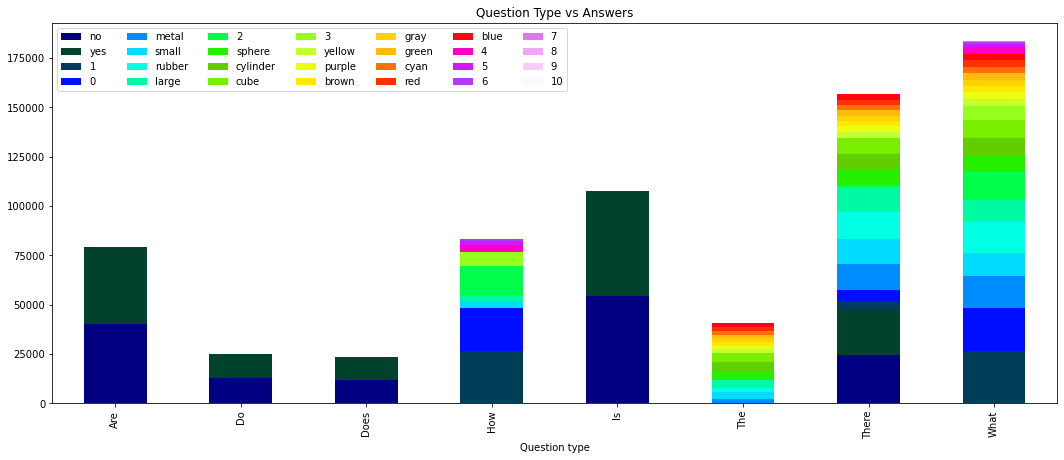

In [14]:
colors = plt.cm.gist_ncar(np.linspace(0, 1, 28))
ax = temp.loc[:,top_aswers].plot.bar(stacked=True, figsize=(18,7), color=colors)
ax.legend(ncol = 7)
plt.title('Question Type vs Answers')
plt.show()

/anaconda/envs/azureml_py36_tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36_tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36_tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.co

/anaconda/envs/azureml_py36_tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36_tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/anaconda/envs/azureml_py36_tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.co

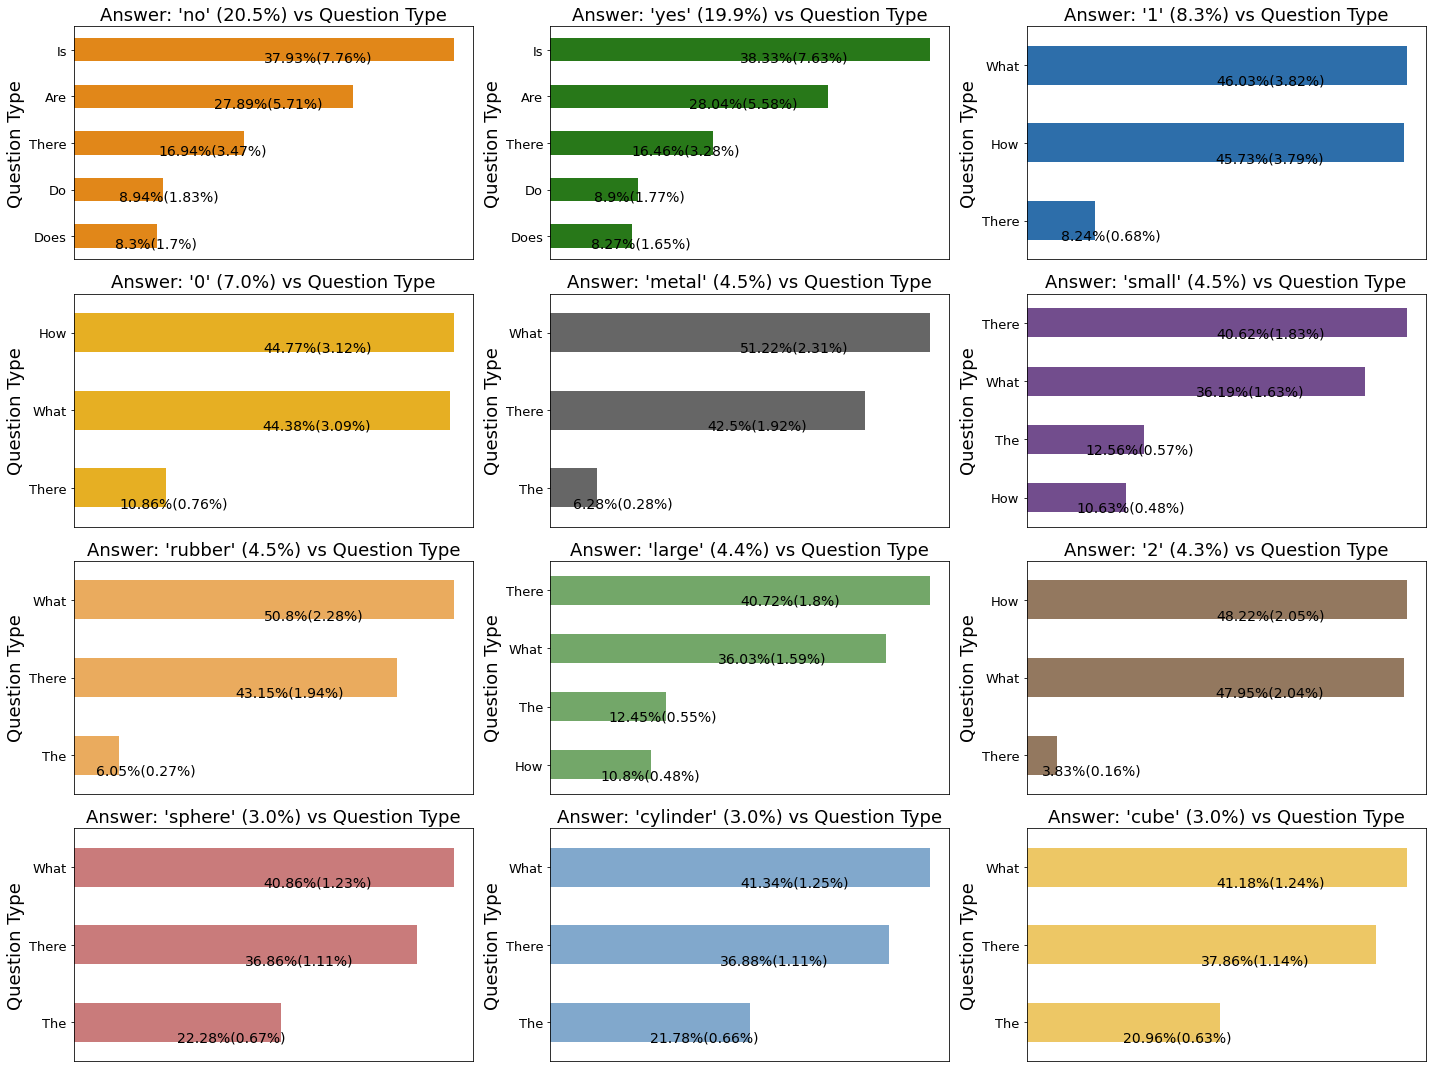

In [15]:
fig = plt.figure()
fig.tight_layout() 
count = 1

colorCodes = [ "#E18719", "#287819", "#2D6EAA", "#E6AF23", "#666666","#724D8D", "#EAAB5E", "#73A769","#93785F",
              "#C97B7B", "#81A8CC", "#EDC765", "#858585","#957AA9", "#F3CFA3","#B4D0AF", "#BEADA0", "#E4BDBD", 
              "#ABC5DD", "#F4DB9C", "#A3A3A3"]

answer_frequncy = sorted(list(getFrequnctDict(temp_df,'Answer').items()),key = lambda x: x[1],reverse=True)

for _type,_ in answer_frequncy[:12]:
    percentage = str(round((len(temp_df[temp_df['Answer']==_type])/len(temp_df))*100,1))+'%'
    plt.subplot(4, 3, count)
    temp = temp_df[temp_df['Answer']==_type]
    ax = temp['Question type'].value_counts()[:10][::-1].plot(kind='barh', figsize=(20,15),color=colorCodes[count-1], fontsize=13)
    ax.set_alpha(0.8)   
    ax.set_title("Answer: '" + _type + "' (" + percentage + ") vs Question Type" , fontsize=18)
    ax.set_ylabel("Question Type", fontsize=18)
    ax.get_xaxis().set_visible(False)
    for i in ax.patches:
        ax.text(i.get_width()/2, i.get_y(), str(round((i.get_width()/len(temp))*100, 2))+'%' + "(" +
                str(round((i.get_width()/len(temp_df))*100, 2))+'%' +")", fontsize=14,color='black')
        
    count += 1

fig.tight_layout()
plt.show()